## Filtering and normalization


######  edgeRUsersGuide() about normalisation, 2.7.1
> edgeR is concerned with differential expression analysis rather than with the quantification of
expression levels. It is concerned with relative changes in expression levels between conditions,
but not directly with estimating absolute expression levels.




First let's load edgeR and then see if the data loads.

In [1]:
library(edgeR)
raw_data <- read.delim("RNA-Seq-counts.txt")
head(raw_data)

Loading required package: limma


ID,WCFS1.glc.1,WCFS1.glc.2,WCFS1.rib.1,WCFS1.rib.2,NC8.glc.1,NC8.glc.2,NC8.rib.1,NC8.rib.2
lp_0001,8100,9599,8144,7000,7117,8278,7457,6980
lp_0002,12679,15856,11539,11049,10815,14348,10552,10735
lp_0004,1795,1946,1470,1607,1489,1407,1587,1699
lp_0005,8538,8740,5699,7402,6497,8565,6581,8342
lp_0009,56040,42130,31941,23500,61965,37353,20498,18188
lp_0010,105615,90094,60086,52584,103873,91726,45530,44802


###  initiate edgeR. 
> edgeR stores data in a simple list-based data object called a DGEList. This type of object is
easy to use because it can be manipulated like any list in R. The function readDGE makes a
DGEList object directly. If the table of counts is already available as a matrix or a data.frame,
x say, then a DGEList

### use a `DGEList` 
##### <sub>( i guess ) </sub>
> A Differential Gene Expression List Object from the edgeR library

I think the thing we're doing is Differential gene expression analysis?
> Differential expression analysis means taking the normalised read count data and performing statistical analysis to discover quantitative changes in expression levels between experimental groups.

So we have to normalise the data before we can do stuff. Good thing we're using edgeR
> edgeR is concerned with differential expression analysis rather than with the quantification of
expression levels.

The counts we're using for these statistics will conists of the RNA.Seq read counts of two samples of L. Plantarum (strain WCFS1) grown on Glucose and two grown on Ribose. Glucose being the reference sample. 

###### Todo/discuss
For now, the gene attribute will only hold gene identifiers. DGElist can have gene annotation in this field.
also see the org.Mm.eg.db package.




In [2]:
data_as_DGElist <- DGEList(counts=raw_data[,2:5], group=c("glucose","glucose","ribose","ribose"),genes=raw_data[1])
# Extracting values by index from a list or object in R is done as follows 
# [startrow:endrow,startcol:endcol]
data_as_DGElist$counts[1:5,] # show the first 5 rows (yes, 0:5 would work, too.)

WCFS1.glc.1,WCFS1.glc.2,WCFS1.rib.1,WCFS1.rib.2
8100,9599,8144,7000
12679,15856,11539,11049
1795,1946,1470,1607
8538,8740,5699,7402
56040,42130,31941,23500


### `filterByExpr`: Filter Genes By Expression Level
> Determine which genes have sufficiently large counts to be retained in a statistical analysis.


In [3]:
keepables = filterByExpr(data_as_DGElist)
filtered_data = data_as_DGElist[keepables,]

### Normalisation using `calcNormFactors`
more about TMM normalisation here https://www.biostars.org/p/269870/

the next part is taken literally from the workflow example here https://f1000research.com/articles/5-1438 and is also described in the edgeR manual.
> Normalization for composition bias
Normalization by trimmed mean of M values (TMM)17 is performed by using the calcNormFactors function, which returns the DGEList argument with only the norm.factors changed. It calculates a set of normalization factors, one for each sample, to eliminate composition biases between libraries.

The normalisation is a complex process
- step 1: remove all untranscribed genes
- step 2: pick reference sample:
    - this is done by edgeR. it scales each sample by the total read counts then determines the 75th quantiles and takes the average of each quantile to determine which sample to use as reference, based on which has it's 75th quantile closest to average of all quantiles.
- step 3: select genes for scaling factors
    - first, remove 60% of biased genes and 10% of high and lowly expressed gene counts. The remaining list will be used to determine the scaling factor. (custom thresholds can be set)


In [4]:
normalised_data <- calcNormFactors(filtered_data)
normalised_data$counts[1:3,]

WCFS1.glc.1,WCFS1.glc.2,WCFS1.rib.1,WCFS1.rib.2
8100,9599,8144,7000
12679,15856,11539,11049
1795,1946,1470,1607


Now we can plot MDS
> Multidimensional scaling (MDS) is a means of visualizing the level of similarity of individual cases of a dataset. MDS is used to translate "information about the pairwise 'distances' among a set of n objects or individuals" into a configuration of n points mapped into an abstract Cartesian space.

distances on the plot approximate the expression differences between the samples. 

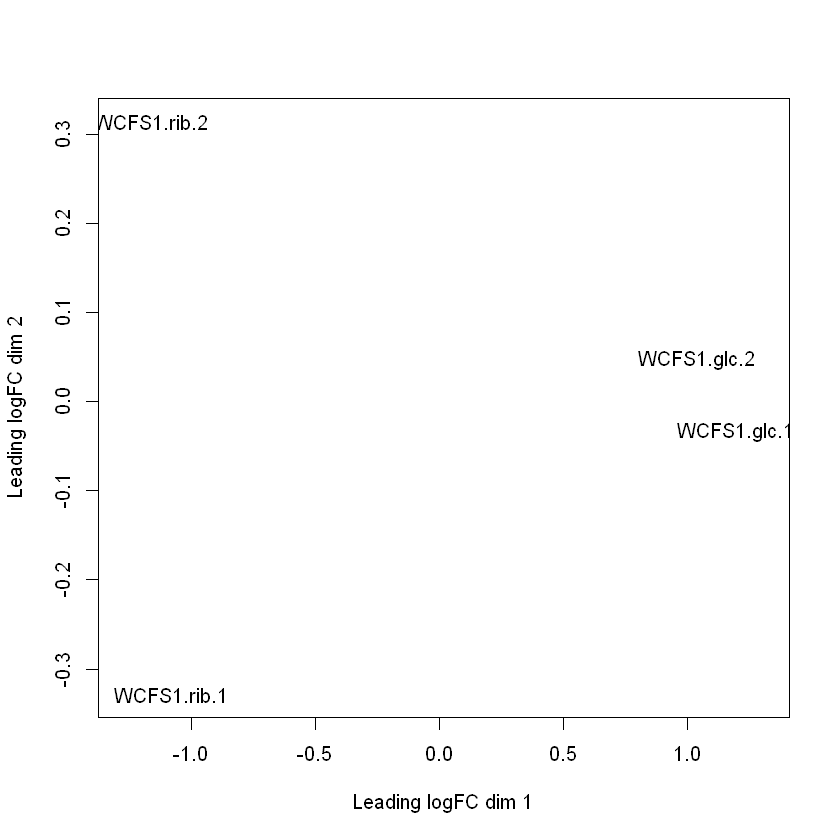

In [5]:
plotMDS(normalised_data)

Now lets estimate the dispersion and plot it using plotBCV
> The square root of dispersion is the coefficient of biological variation

> The BCV is the square root of the negative binomial dispersion. This function displays the common, trended and genewise BCV estimates. 


Design matrix not provided. Switch to the classic mode.


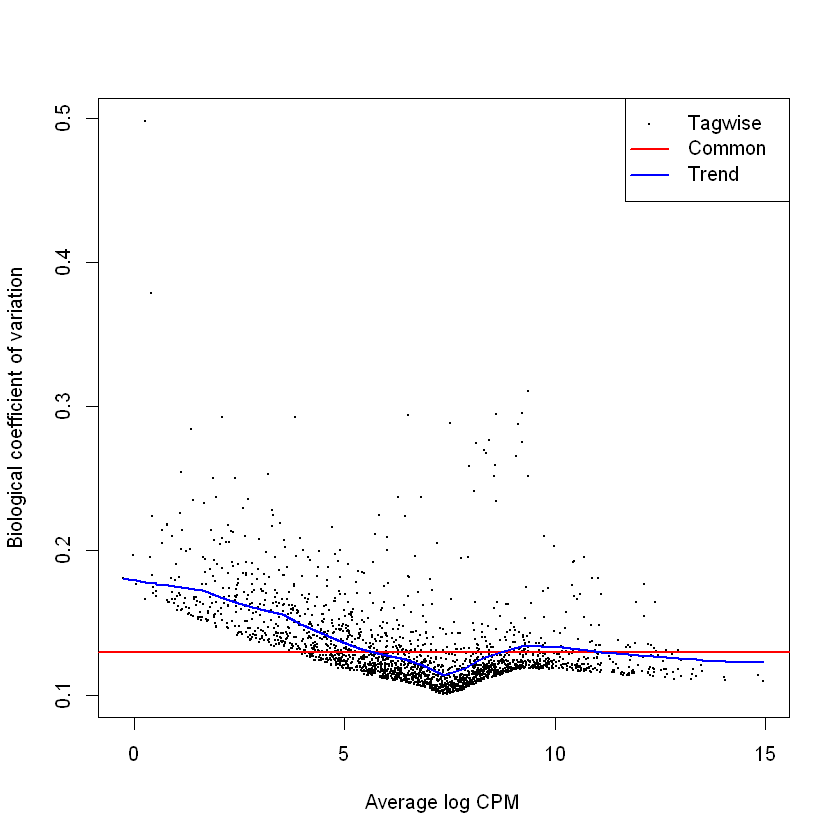

In [6]:
normalised_data_dispersion <- estimateDisp(normalised_data)

common <- estimateGLMCommonDisp(normalised_data)
trend <- estimateGLMTrendedDisp(normalised_data)
tag <- estimateGLMTagwiseDisp(common)

plotBCV(normalised_data_dispersion)

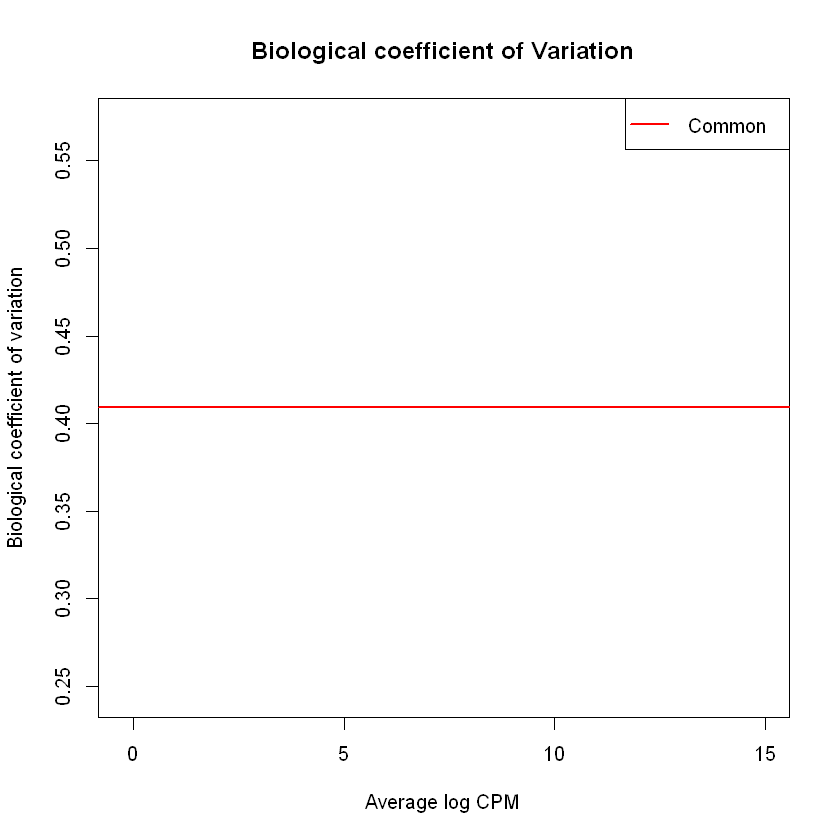

In [7]:
plotBCV(common, main="Biological coefficient of Variation")

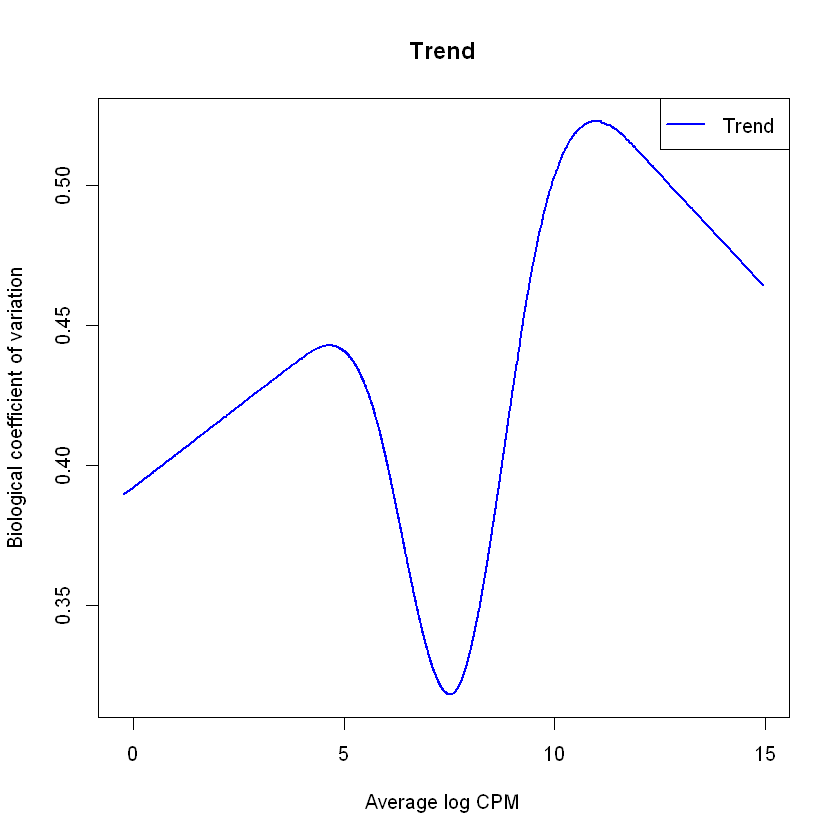

In [8]:
plotBCV(trend, main="Trend")

### what does this trend describe?


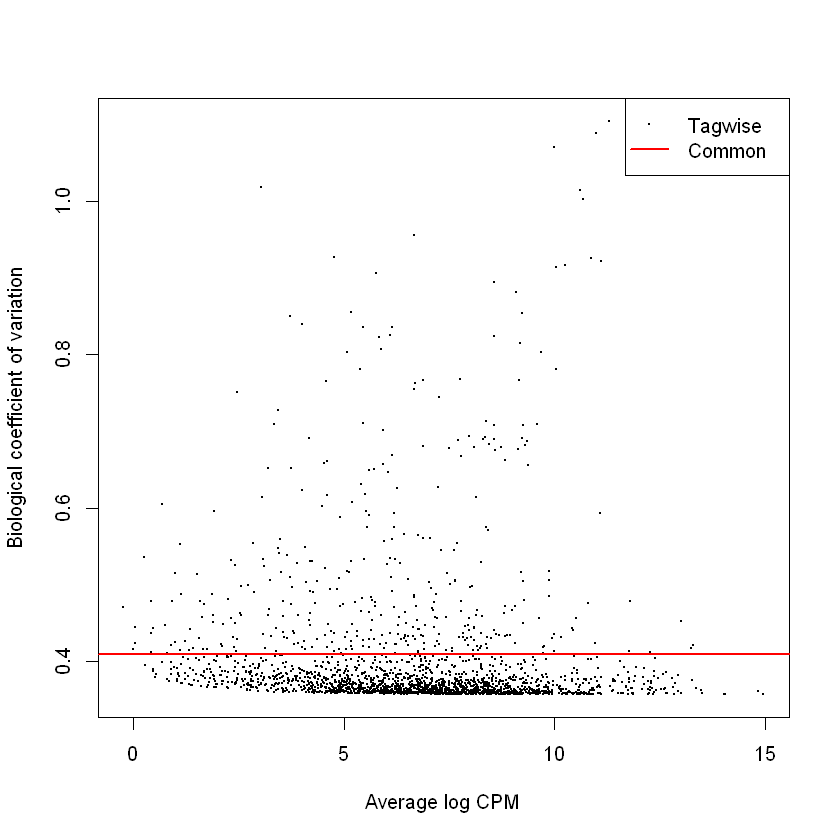

In [9]:
plotBCV(tag)

### What exactly am I seeing here?

###  Mean variance
> Appropriate modelling of the mean-variance relationship in DGE data is important for making inferences about differential expression

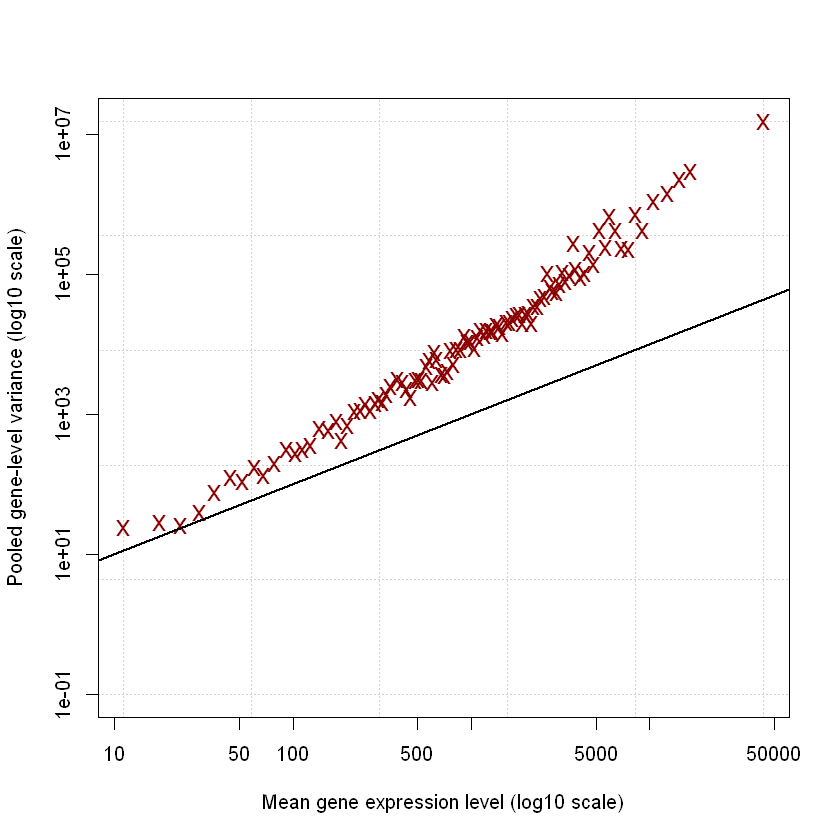

In [10]:
# plot mean variance
plotMeanVar(normalised_data_dispersion)

## Genewise Negative Binomial Generalized Linear Models
> Fit a negative binomial generalized log-linear model to the read counts for each gene. Conduct genewise statistical tests for a given coefficient or coefficient contrast.

should check this out https://support.bioconductor.org/p/86744/

,ID,logFC,logCPM,LR,PValue,FDR
2198,lp_3658,8.148504,11.986962,1147.0129,2.000241e-251,4.370528e-248
2200,lp_3660,8.413817,11.294598,1067.0176,4.869937e-234,5.320406e-231
2199,lp_3659,8.156501,10.991262,907.0790,2.837480e-199,2.066631e-196
1347,lp_2152,6.046024,10.877858,776.6222,6.529931e-171,3.566975e-168
1346,lp_2151,5.986137,11.105288,735.8136,4.876051e-162,2.130834e-159
1349,lp_2154,5.904731,10.045591,707.0982,8.553977e-156,3.115073e-153
258,lp_0371,5.682625,8.559853,664.2586,1.770896e-146,5.527726e-144
1348,lp_2153,5.927661,10.261084,636.0230,2.448409e-140,6.687218e-138
172,lp_0262,-6.399127,6.675371,544.9672,1.566205e-120,3.802397e-118
360,lp_0576,-4.794152,9.186096,535.5136,1.784221e-118,3.898522e-116


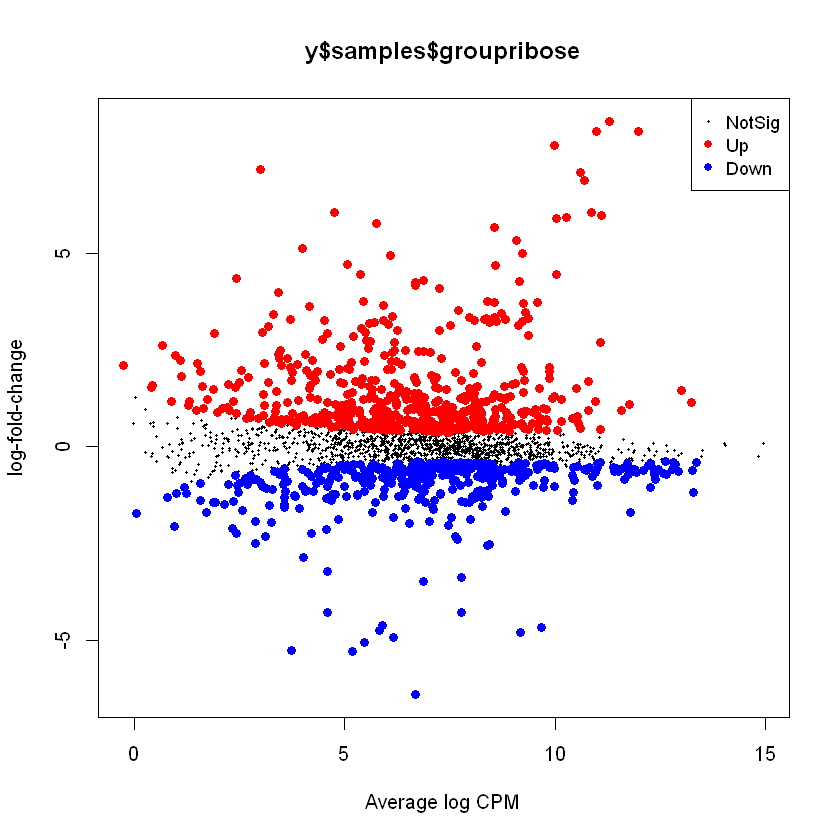

In [11]:
glf <- glmFit(normalised_data_dispersion)
qlf <- glmLRT(glf)

topTags(qlf, mai

plotMD(qlf)

In [12]:
summary(decideTests(qlf))

       y$samples$groupribose
Down                     382
NotSig                  1282
Up                       521